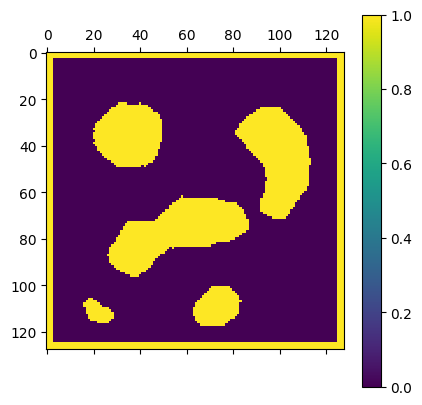

In [1]:
import numpy as np
import math
from matplotlib import pyplot as plt
from PIL import Image

from Point import Point

# Load grid map
image = Image.open("Data/map0.png").convert("L")
grid_map = np.array(image.getdata()).reshape(image.size[0], image.size[1]) / 255
# binarize the image
grid_map[grid_map > 0.5] = 1
grid_map[grid_map <= 0.5] = 0
# Invert colors to make 0 -> free and 1 -> occupied
grid_map = (grid_map * -1) + 1
# Show grid map
plt.matshow(grid_map)
plt.colorbar()
plt.show()

def plot(grid_map, states, edges, path):
    plt.figure(figsize=(10, 10))
    plt.matshow(grid_map, fignum=0)
    for i,v in enumerate(states):
        plt.plot(v.y, v.x, "+w")
        plt.text(v.y, v.x, i, fontsize=14, color="w")

    for e in edges:
        plt.plot(
            [states[e[0]].y, states[e[1]].y],
            [states[e[0]].x, states[e[1]].x],
            "--g",
        )

    for i in range(1, len(path)):
        plt.plot(
            [states[path[i - 1]].y, states[path[i]].y],
            [states[path[i - 1]].x, states[path[i]].x],
            "r",
        )
    # Start
    plt.plot(states[0].y, states[0].x, "r*")
    # Goal
    plt.plot(states[-1].y, states[-1].x, "g*")

path = []


def fill_path(vertices, edges):
    edges.reverse()
    path = [edges[0][1]]
    next_v = edges[0][0]
    i = 1
    while next_v != 0:
        while edges[i][1] != next_v:
            i += 1
        path.append(edges[i][1])
        next_v = edges[i][0]
    path.append(0)
    edges.reverse()
    path.reverse()
    return vertices, edges, path

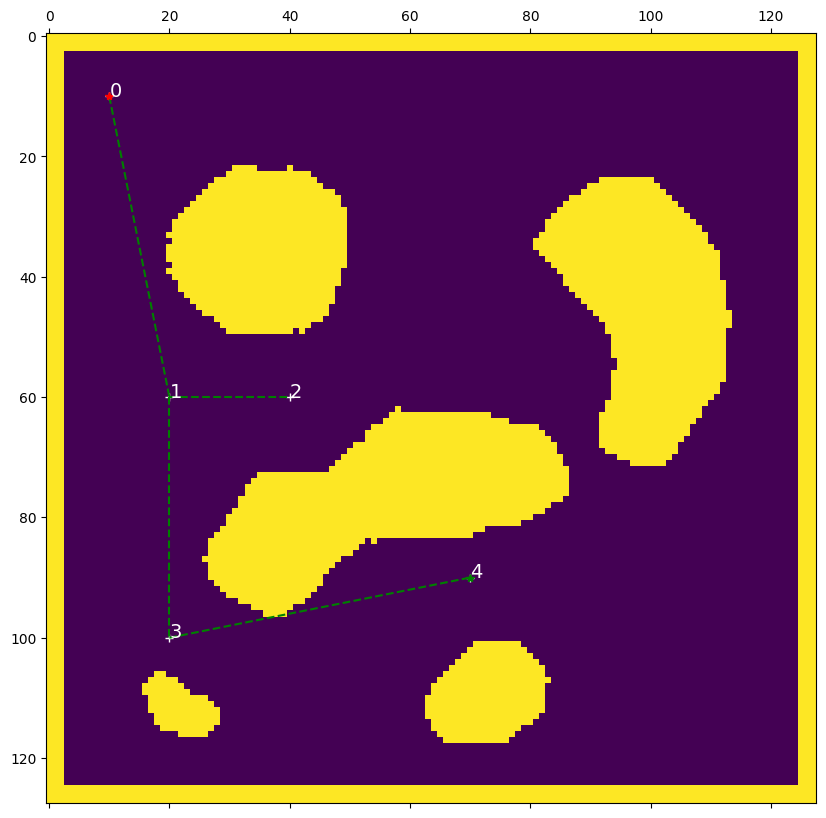

In [22]:
q_start = Point(10, 10)
q_goal = Point(90, 70)

states = [q_start]
edges = []

# RRT algorithm
q_dummy=Point(60,20)      # dummy1
states.append(q_dummy)

q_dummy = Point(60, 40)  # dummy2
states.append(q_dummy)

q_dummy = Point(100, 20)  # dummy3
states.append(q_dummy)

# list of states or vertices that make an edge
edges.append((0, 1))
edges.append((1, 2))
edges.append((1, 3))
edges.append((3, 4))
# RRT algorithm

states.append(q_goal)
path=[]

# _, _, path = fill_path(states, edges)
plot(grid_map, states, edges, path)

## Define RRT

In [ ]:
class RRT:

    def __init__(self, grid_map, K, delta_q, p, q_start, q_goal):
        self.c_space = grid_map
        self.K = K
        self.delta_q = delta_q
        self.p = p
        self.q_start = q_start
        self.q_goal = q_goal

    def run_RRT(self):
        min_dist = 5
        G_vertex = [self.q_start]
        G_edge = []

        c_free_space = []
        for i, j in np.ndindex(self.c_space.shape):
            if self.c_space[i][j] == 0:
                c_free_space.append(Point(i, j))

        for k in range(self.K):
            q_rand = self.RAND_CONF(c_free_space, self.p, self.q_goal)
            id, q_near = self.NEAREST_VERTEX(q_rand=q_rand, G=G_vertex)
            q_new = self.NEW_CONF(q_near=q_near, q_rand=q_rand, delta_q=self.delta_q)
            if self.IS_FREE_SEGMENT(q_near=q_near, q_new=q_new, c_space=self.c_space):
                G_vertex.append(q_new)
                G_edge.append((id, len(G_vertex)-1))
                if self.DISTANCE(q_new=q_new, q_goal=self.q_goal) < min_dist:
                    G_vertex.append(self.q_goal)
                    G_edge.append((len(G_vertex)-2, len(G_vertex)-1))
                    return G_vertex, G_edge

        return G_vertex, G_edge
    
    def smoothing_function(self, path, G_vertex):
        smooth_path = [path[0]]
        current_idx = path[0]
        current_i = 0
        temp_idx = -1
        temp_i = 0
        while current_idx != path[-1]:
            for i, idx in enumerate(path[current_i:]):
                if self.IS_FREE_SEGMENT(G_vertex[current_idx], G_vertex[idx], self.c_space):
                    temp_idx = idx
                    temp_i = i
            
            current_idx = temp_idx
            current_i = temp_i
            smooth_path.append(current_idx)

        return smooth_path


    def RAND_CONF(self, c_free_space, p, q_goal):
        if np.random.rand() >= (1 - p):
            return q_goal

        else:
            return np.random.choice(c_free_space)

    def NEAREST_VERTEX(self, q_rand, G):
        min_dist = np.inf
        idx = -1
        for i, point in enumerate(G):
            dist = q_rand.dist(point)
            if dist < min_dist:
                q_near = point
                idx = i
                min_dist = dist

        return idx, q_near

    def NEW_CONF(self, q_near, q_rand, delta_q):
        q_near_vector = q_near.vector(q_rand)
        if q_near_vector.norm() < delta_q:
            return q_rand
        q_near_vector_unit = Point(q_near_vector.x/q_near_vector.norm(), q_near_vector.y/q_near_vector.norm())
        q_new = Point(q_near.x + delta_q * q_near_vector_unit.x,
                      q_near.y + delta_q * q_near_vector_unit.y)
        q_new = Point(round(q_new.x), round(q_new.y))
        return q_new
    
    def IS_FREE_SEGMENT(self, q_near, q_new, c_space):
        q_queue = [(q_near, q_new)]
        
        num_bisection = round(q_near.vector(q_new).norm())

        if c_space[q_new.x][q_new.y] == 1:
            return False
        
        for i in range(0, num_bisection):
            q1, q2 = q_queue.pop(0)
            q_half = Point(round((q1.x + q2.x)/2), round((q1.y + q2.y)/2))
            if c_space[q_half.x][q_half.y] == 1:
                return False
            q_queue.append((q1, q_half))
            q_queue.append((q_half, q2))
        
        return True



    def DISTANCE(self, q_new, q_goal):
        return q_goal.dist(q_new)

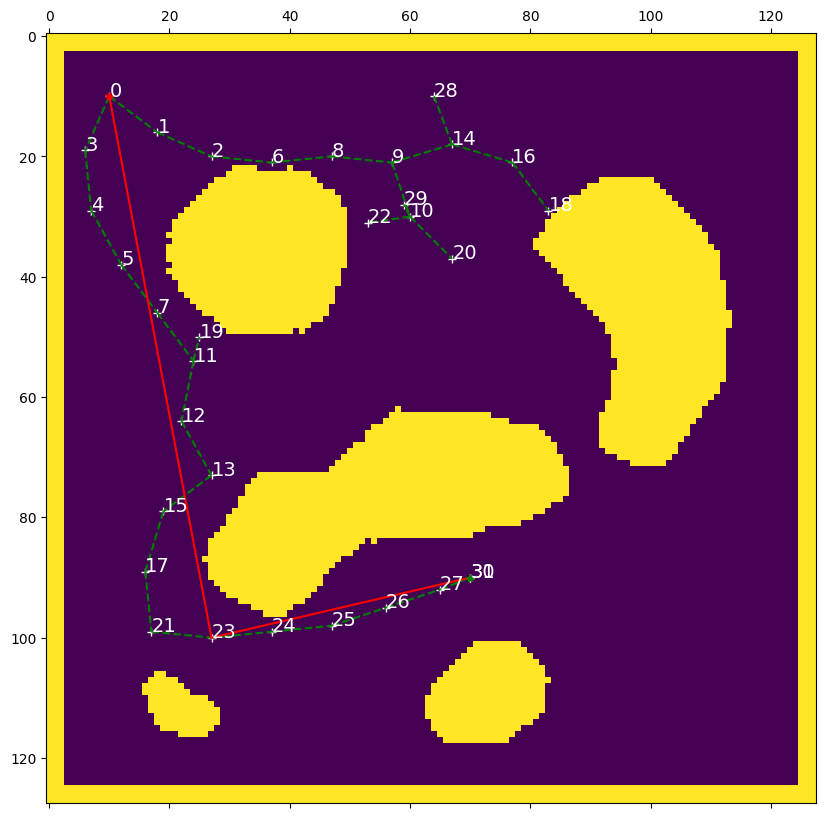

In [99]:
rrt = RRT(grid_map=grid_map, K=1000, delta_q=10, p=0.2, q_start=q_start, q_goal=q_goal)
states, edges = rrt.run_RRT()
path = []
_, _, path = fill_path(states, edges)
smooth_path = rrt.smoothing_function(path, states)
plot(grid_map, states, edges, smooth_path)